In [ ]:
# Import các thư viện cần thiết
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


In [ ]:
# Đổi thư mục,làm việc của Colab
# %cd /content/drive/MyDrive/liar_dataset


In [ ]:
# Tải dữ liệu
train_df = pd.read_csv("train.tsv", sep='\t', header=None)
test_df = pd.read_csv("test.tsv", sep='\t', header=None)
val_df = pd.read_csv("valid.tsv", sep='\t', header=None)


In [ ]:
# Từ điển nhãn dạng chữ sang số
label_mapping = {
    'true' : 1,
    'false' : 0,
    'mostly-true' : 1,
    'half-true' : 1,
    'barely-true' : 0,
    'pants-fire' : 0,
}


In [ ]:
# Chuyển cột nhẫn thành giá trị số
train_df[1] = train_df[1].map(label_mapping)
test_df[1] = test_df[1].map(label_mapping)
val_df[1] = val_df[1].map(label_mapping)


In [ ]:
# Tiền xử lí văn bản
def preprocess_text(text):
  # Chuyển chữ viết hoa thành viết thường
  text = text.lower()

  # Thay thế các ký tự không phải chữ cái, số hay khoảng trắng
  text = text.replace(r'[^\w\s]', '')
  return text


In [ ]:
# Preprocessing text
train_df[2] = train_df[2].apply(preprocess_text)
test_df[2] = test_df[2].apply(preprocess_text)
val_df[2] = val_df[2].apply(preprocess_text)


In [ ]:
# Chuyển series text và nhãn thành list
train_texts = train_df[2].tolist()
y_train = train_df[1].tolist()

test_texts = test_df[2].tolist()
y_test = test_df[1].tolist()

val_texxts = val_df[2].tolist()
y_val = val_df[1].tolist()

In [ ]:
# Tạo TextVectorization để chuyển đổi văn bản thành các chỉ số
tokenizer = Tokenizer(num_words=20000)# Từ điển có 20000 từ
maxlen = 256# Độ dài tối đa cảu chuỗi

tokenizer.fit_on_texts(train_texts)# Train Tokenixer

# Chuyển text thành chuỗi số nguyên theo từ điển
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
val_sequences = tokenizer.texts_to_sequences(val_texxts)

# Padding de text co cung do dai
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=maxlen)


In [ ]:
# Encoder của transformers
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout)(inputs, inputs)

    # Residual
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation=None)(x)

    # Residual
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    return x

# Hàm tạo model
def build_model(vocab_size, sequence_length, head_size, num_heads, ff_dim, dropout=0):
    inputs = layers.Input(shape=(sequence_length,))

    # Lớp embedding cho các từ
    token_emb = layers.Embedding(input_dim=vocab_size, output_dim=head_size)(inputs)

    # Lớp embedding cho các vị trí
    pos = tf.range(start=0, limit=sequence_length, delta=1)
    pos_emb = layers.Embedding(input_dim=sequence_length, output_dim=head_size)(pos)
    pos_emb = tf.expand_dims(pos_emb, axis=0)
    x = token_emb + pos_emb  # Cộng embeddings cho từ và vị trí

    # Transformer encoder
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Lớp pooling và dropout
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)

    # Lớp phân loại
    x = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs, x)
    return model

# Tham số mô hình
vocab_size = 20000 # Tổng số từ trong từ điển
sequence_length = 256 # Độ dài text
head_size = 32  # Kích thước đầu ra của mỗi head
num_heads = 8  # Số lượng head
ff_dim = 512  # Kích thước của feed-forward
dropout = 0.3

model = build_model(vocab_size, sequence_length, head_size, num_heads, ff_dim, dropout)

# Biên dịch model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Tóm tắt mô hình
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 256, 32)      640000      ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256, 32)     0           ['embedding[0][0]']              
 da)                                                                                              
                                                                                                  
 multi_head_attention (MultiHea  (None, 256, 32)     33568       ['tf.__operators__.add[0][0]'

In [ ]:
# Callback dừng train khi loss trên tập validation không cải thiện sau 3 epoch và trả về trọng số tốt nhất
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Huấn luyện mô hình
history = model.fit(tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train), epochs=20, batch_size=32, validation_data=[tf.convert_to_tensor(x_val), tf.convert_to_tensor(y_val)], shuffle=True, callbacks=[early_stopping])


Epoch 1/20
320/320 [==============================] - 173s 536ms/step - loss: 0.7000 - accuracy: 0.5356 - val_loss: 0.6906 - val_accuracy: 0.5202
Epoch 2/20
320/320 [==============================] - 173s 540ms/step - loss: 0.6903 - accuracy: 0.5469 - val_loss: 0.6904 - val_accuracy: 0.5202
Epoch 3/20
320/320 [==============================] - 174s 543ms/step - loss: 0.6852 - accuracy: 0.5558 - val_loss: 0.7071 - val_accuracy: 0.5202
Epoch 4/20
320/320 [==============================] - 176s 550ms/step - loss: 0.6831 - accuracy: 0.5614 - val_loss: 0.6833 - val_accuracy: 0.5709
Epoch 5/20
320/320 [==============================] - 162s 507ms/step - loss: 0.6777 - accuracy: 0.5701 - val_loss: 0.6803 - val_accuracy: 0.5670
Epoch 6/20
320/320 [==============================] - 151s 472ms/step - loss: 0.6708 - accuracy: 0.5830 - val_loss: 0.6974 - val_accuracy: 0.4922
Epoch 7/20
320/320 [==============================] - 150s 469ms/step - loss: 0.6637 - accuracy: 0.5943 - val_loss: 0.7117 -

In [ ]:
# Đánh giá mô hình trên tập dữ liệu kiểm tra
test_loss, test_accuracy = model.evaluate(tf.convert_to_tensor(x_test), tf.convert_to_tensor(y_test))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 6s 151ms/step - loss: 0.6553 - accuracy: 0.6314
Test Loss: 0.6552638411521912
Test Accuracy: 0.6314128041267395


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Dự đoán trên dữ liệu kiểm tra
y_pred_prob = model.predict(tf.convert_to_tensor(x_test))
y_pred = (y_pred_prob > 0.5).astype(int)  # Chuyển xác suất thành nhãn (0 hoặc 1)

# In ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# In báo cáo phân loại
report = classification_report(y_test, y_pred, target_names=['false', 'true'])
print("Classification Report:")
print(report)

40/40 [==============================] - 7s 152ms/step
Confusion Matrix:
[[292 261]
 [206 508]]
Classification Report:
              precision    recall  f1-score   support

       false       0.59      0.53      0.56       553
        true       0.66      0.71      0.69       714

    accuracy                           0.63      1267
   macro avg       0.62      0.62      0.62      1267
weighted avg       0.63      0.63      0.63      1267



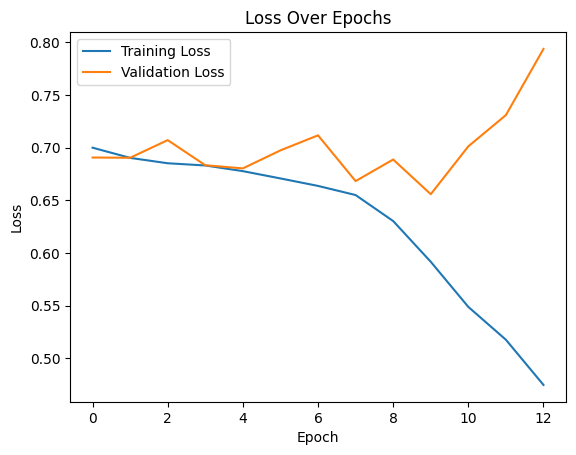

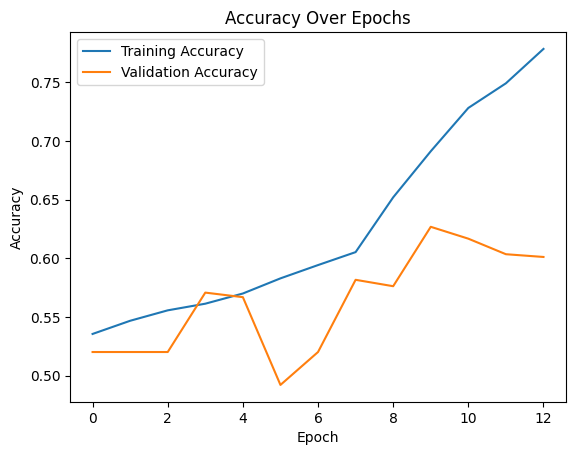

In [ ]:
import matplotlib.pyplot as plt

# Vẽ đồ thị mất mát
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Vẽ đồ thị độ chính xác
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

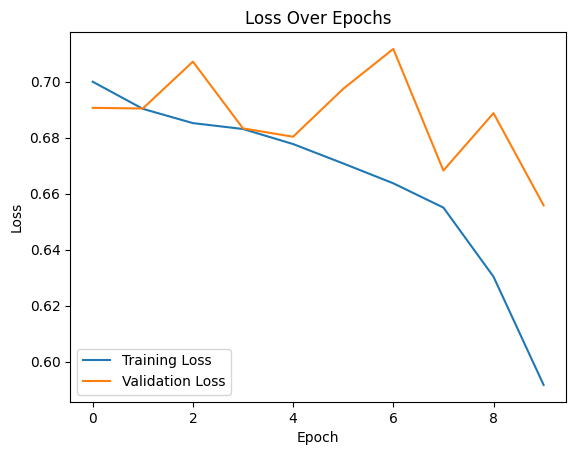

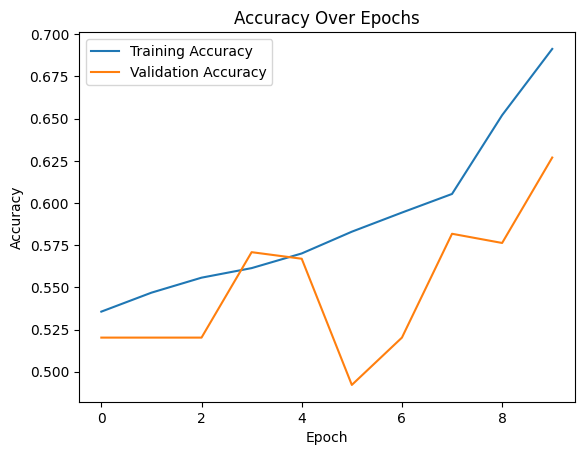

In [ ]:
val_loss = history.history['val_loss'][:-3]
loss = history.history['loss'][:-3]
val_accuracy = history.history['val_accuracy'][:-3]
accuracy = history.history['accuracy'][:-3]
# Vẽ đồ thị mất mát
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Vẽ đồ thị độ chính xác
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Tính các chỉ số đánh giá
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.6605981794538361
Recall: 0.711484593837535
F1 Score: 0.6850977747808497


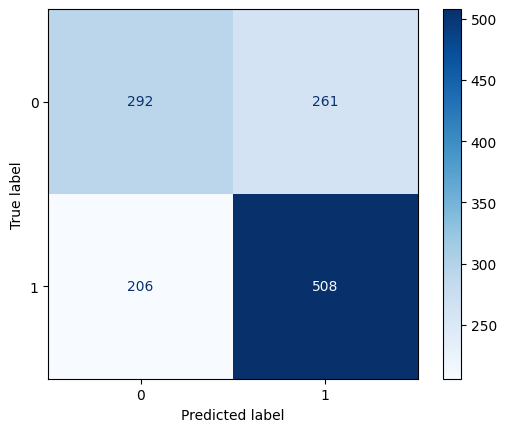

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Tạo ma trận nhầm lẫn
# cm = confusion_matrix(y_test, y_pred)

# Vẽ Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.show()

D:\anaconda3\envs\my_env\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


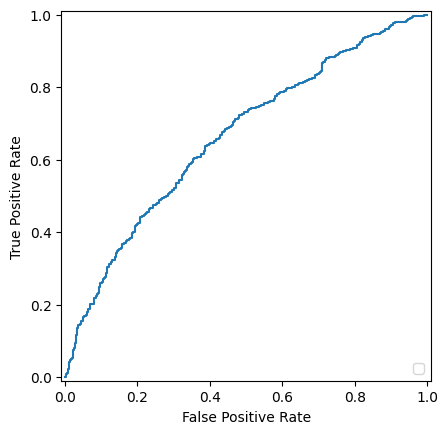

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay
# Tính FPR và TPR
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Vẽ ROC Curve
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

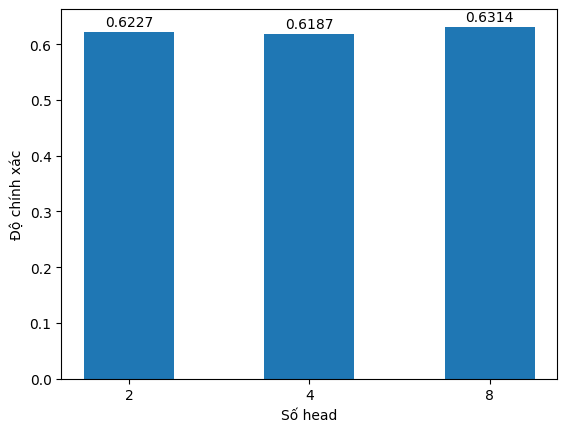

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu mẫu
categories = ['2', '4', '8']
values = [0.6227, 0.6187, 0.6314]

# Vẽ đồ thị cột
plt.bar(categories, values, width=0.5)

# Thêm tiêu đề và nhãn trục
# plt.title('Biểu đồ so sánh độ chính xác trên tập test với số head của lớp multi-head attention khác nhau.')
plt.xlabel('Số head')
plt.ylabel('Độ chính xác')

for i in range(len(categories)):
    plt.text(i, values[i] + 0.01, f'{values[i]}', ha='center')

# Hiển thị đồ thị
plt.show()
